In [1]:
import random

import numpy as np

import pandas as pd

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import xgboost as xgb

import matplotlib.pyplot as plt

import seaborn as sns

from tqdm import tqdm

# import shap

# import optuna

In [2]:
path = '../data/netflix_stock_price/NFLX.csv'

df = pd.read_csv(path)

df = df.sort_values('Date', ascending=True)

# df = df.drop(columns=['Adj Close', 'Volume'])

date_column = 'Date'
numerical_columns = df.columns.to_list()
numerical_columns.remove(date_column)

k = 3
lower_quartile = df[numerical_columns].quantile(0.25)
upper_quartile = df[numerical_columns].quantile(0.75)
iqr = upper_quartile - lower_quartile
for column in numerical_columns:
    outlier_mask = (df[column] < lower_quartile[column] - k * iqr[column]) | (df[column] > upper_quartile[column] + k * iqr[column])
    df = df[~outlier_mask]

df[numerical_columns] = df[numerical_columns].astype(float)

df

,Date,Open,High,Low,Close,Adj Close,Volume
1,2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800.0
2,2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400.0
3,2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,6757800.0
4,2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,10154200.0
5,2002-05-31,1.078571,1.078571,1.071429,1.076429,1.076429,8464400.0
...,...,...,...,...,...,...,...
5039,2022-05-27,193.190002,195.250000,190.369995,195.190002,195.190002,8586000.0
5040,2022-05-31,196.179993,199.949997,190.800003,197.440002,197.440002,11398500.0
5041,2022-06-01,198.699997,202.740005,191.660004,192.910004,192.910004,8416200.0
5042,2022-06-02,192.020004,205.470001,191.720001,205.089996,205.089996,9623100.0


Text(0, 0.5, 'Normalized Price')

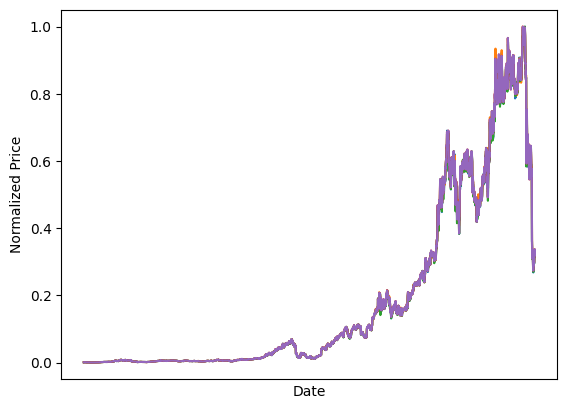

In [44]:
fig = plt.Figure((30, 10))

price_columns = numerical_columns[:]
price_columns.remove('Volume')

for column in price_columns:
    sns.lineplot(df, x=date_column, y=column)

plt.xticks([])
plt.ylabel('Normalized Price')

In [4]:
df['Price_Range'] = df['High'] - df['Low']
df['Daily_Return'] = df['Close'].pct_change()

df['MA_5'] = df['Close'].rolling(window=5).mean()
df['MA_10'] = df['Close'].rolling(window=10).mean()
df['MA_20'] = df['Close'].rolling(window=20).mean()

df['Momentum_5'] = df['Close'].diff(5)
df['Momentum_10'] = df['Close'].diff(10)

df['Volatility_5'] = df['Close'].rolling(window=5).std()
df['Volatility_10'] = df['Close'].rolling(window=10).std()

delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

df = df.dropna()

# target_column = 'Close'
feature_columns = df.columns.to_list()
# feature_columns.remove(target_column)
feature_columns.remove(date_column)

df

,Date,Open,High,Low,Close,Adj Close,Volume,Price_Range,Daily_Return,MA_5,MA_10,MA_20,Momentum_5,Momentum_10,Volatility_5,Volatility_10,RSI
20,2002-06-21,0.982143,0.989286,0.947857,0.979286,0.979286,2346400.0,0.041429,0.023134,0.944143,1.019286,1.075286,-0.007143,-0.139285,0.027652,0.093491,34.789094
21,2002-06-24,0.979286,1.014286,0.957143,0.978571,0.978571,2567600.0,0.057143,-0.000730,0.955429,1.001500,1.063714,0.056428,-0.177858,0.027942,0.080520,35.512712
22,2002-06-25,0.988571,1.007143,0.947143,0.964286,0.964286,3941000.0,0.060000,-0.014598,0.966143,0.982572,1.054071,0.053572,-0.189285,0.012531,0.060578,30.368228
23,2002-06-26,0.963571,0.996429,0.921429,0.988571,0.988571,2924600.0,0.075000,0.025184,0.973571,0.972143,1.048321,0.037142,-0.104286,0.012637,0.046920,28.728445
24,2002-06-27,1.009286,1.018571,0.942857,0.943571,0.943571,3817800.0,0.075714,-0.045520,0.970857,0.958214,1.041929,-0.013572,-0.139286,0.017550,0.026733,29.950966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5039,2022-05-27,193.190002,195.250000,190.369995,195.190002,195.190002,8586000.0,4.880005,0.019802,188.439999,186.628999,185.900000,8.839996,7.550003,5.506956,5.294237,62.569699
5040,2022-05-31,196.179993,199.949997,190.800003,197.440002,197.440002,11398500.0,9.149994,0.011527,190.439999,187.722000,185.799000,10.000000,10.930007,6.732502,6.299714,61.559135
5041,2022-06-01,198.699997,202.740005,191.660004,192.910004,192.910004,8416200.0,11.080001,-0.022944,192.954001,187.957001,185.451000,12.570008,2.350006,3.667293,6.459158,66.840104
5042,2022-06-02,192.020004,205.470001,191.720001,205.089996,205.089996,9623100.0,13.750000,0.063138,196.406000,190.747000,185.505000,17.259994,27.899994,5.367534,7.266795,68.533234


In [5]:
# scaler = {}
# for column in feature_columns:
#     scaler[column] = MinMaxScaler()
#     df.loc[:, [column]] = scaler[column].fit_transform(df[[column]])

feature_scaler = MinMaxScaler()
df.loc[:, feature_columns] = feature_scaler.fit_transform(df[feature_columns])

In [6]:
train_fraction = 0.9
sequence_length = 100
num_samples = len(df[feature_columns].iloc[:-1].values)

X = df[feature_columns].iloc[:-1].values
y = df[feature_columns].iloc[1:].values

num_sequences = len(X) // sequence_length

X = X[:num_sequences * sequence_length]
X = np.array_split(X, num_sequences, axis=0)
X = np.array(X)

y = y[:num_sequences * sequence_length]
y = np.array_split(y, num_sequences, axis=0)
y = np.array(y)

# X.shape, y.shape

train_size = int(train_fraction * num_sequences)

indices = list(range(len(X)))
random.shuffle(indices)

X_train = X[indices[:train_size]]
y_train = y[indices[:train_size]]
X_test = X[indices[train_size:]]
y_test = y[indices[train_size:]]

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

In [7]:
# class TimeSeriesLSTM(nn.Module):
    
#     def __init__(self, input_dim, output_dim, num_layers, hidden_dim, dropout):
#         super(TimeSeriesLSTM, self).__init__()
#         self.lstm1 = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
#         self.bn1 = nn.BatchNorm1d(hidden_dim)
#         self.dropout1 = nn.Dropout(dropout)
        
#         # self.lstm2 = nn.LSTM(hidden_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
#         self.lstm2 = nn.LSTM(2*hidden_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
#         self.bn2 = nn.BatchNorm1d(hidden_dim)
#         self.dropout2 = nn.Dropout(dropout)
        
#         # self.fc1 = nn.Linear(hidden_dim, hidden_dim)
#         self.fc1 = nn.Linear(2*hidden_dim, hidden_dim)
#         self.relu = nn.ReLU()
#         self.fc2 = nn.Linear(hidden_dim, output_dim)
    
#     def forward(self, x):
#         out, _ = self.lstm1(x)
#         # out = self.bn1(out.transpose(1, 2)).transpose(1, 2)
#         out = self.dropout1(out)
        
#         out, _ = self.lstm2(out)
#         # out = self.bn2(out.transpose(1, 2)).transpose(1, 2)
#         out = self.dropout2(out)  

#         out = self.fc1(out)
#         out = self.relu(out)
#         out = self.fc2(out)
#         return out

class TimeSeriesLSTM(nn.Module):
    
    def __init__(self, input_dim, output_dim, num_layers, hidden_dim, dropout):
        super(TimeSeriesLSTM, self).__init__()
        self.lstm = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers,
            batch_first=True,
            bidirectional=True
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(2 * hidden_dim, output_dim)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out)
        out = self.fc(out)
        return out

In [8]:
input_dim, output_dim = X_train.size(-1), X_train.size(-1)
hidden_dim = 512
num_layers = 4
dropout = 0.4
lr = 1e-3
weight_decay = 3e-1

device = torch.device("mps")

# epochs = 1000
# best_loss = float('inf')

# model = TimeSeriesLSTM(
#     input_dim=input_dim,
#     output_dim=output_dim,
#     num_layers=num_layers,
#     hidden_dim=hidden_dim,
#     dropout=dropout
# )
# model = model.to(device)

# criterion = nn.MSELoss()
# optimizer = optim.AdamW(
#     model.parameters(),
#     lr=lr,
#     weight_decay=weight_decay
# )

# # Initial test loss
# model.eval()
# test_loss = 0.0
# with torch.no_grad():
#     for X_batch, y_batch in test_loader:
#         X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#         y_pred = model(X_batch)
#         loss = criterion(y_pred, y_batch)
#         test_loss += loss.item()
# print(f"Initial Test Loss: {test_loss/len(test_loader):.6f}")

# # Training loop with early stopping+
# progress = tqdm(range(epochs))
# for epoch in progress:
#     model.train()
#     train_loss = 0.0
#     for X_batch, y_batch in train_loader:
#         X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#         optimizer.zero_grad()
#         y_pred = model(X_batch)
#         loss = criterion(y_pred, y_batch)
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item()
    
#     # Validation on test set
#     model.eval()
#     test_loss = 0.0
#     with torch.no_grad():
#         for X_batch, y_batch in test_loader:
#             X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#             y_pred = model(X_batch)
#             loss = criterion(y_pred, y_batch)
#             test_loss += loss.item()
#     avg_test_loss = test_loss / len(test_loader)
#     avg_train_loss = train_loss / len(train_loader)
    
#     progress.set_description(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.6f}, Test Loss: {avg_test_loss:.6f}")
    
#     # Save best model
#     if avg_test_loss < best_loss:
#         best_loss = avg_test_loss
#         best_model_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        
# # Load best model
# model = TimeSeriesLSTM(
#     input_dim=input_dim,
#     output_dim=output_dim,
#     num_layers=num_layers,
#     hidden_dim=hidden_dim,
#     dropout=dropout
# )
# model.load_state_dict(best_model_state)
# model = model.to(device)

# # Best test loss
# model.eval()
# test_loss = 0.0
# with torch.no_grad():
#     for X_batch, y_batch in test_loader:
#         X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#         y_pred = model(X_batch)
#         loss = criterion(y_pred, y_batch)
#         test_loss += loss.item()
# print(f"Best Test Loss: {test_loss/len(test_loader):.6f}")

# torch.save(model.state_dict(), '../data/netflix_stock_price/best_model.pth')

In [9]:
model = TimeSeriesLSTM(
    input_dim=input_dim,
    output_dim=output_dim,
    num_layers=num_layers,
    hidden_dim=hidden_dim,
    dropout=dropout
)
state_dict = torch.load('../data/netflix_stock_price/best_model.pth')
model.load_state_dict(state_dict)
model = model.to(device)

seed_sequences = 2
pred_sequences = 2

X_sample = torch.tensor(X[-(seed_sequences+pred_sequences):-pred_sequences].reshape(1, -1, input_dim).squeeze(), dtype=torch.float32).unsqueeze(0).to(device)
with torch.no_grad():
    for _ in tqdm(range(pred_sequences * sequence_length)):
        y_pred = model(X_sample)[:, -1, :].unsqueeze(1)
        X_sample = torch.cat((X_sample, y_pred), dim=1)

preds = X_sample.detach().cpu().numpy().squeeze()

# plt.plot(range(seed_sequences * sequence_length), preds[:seed_sequences * sequence_length], '--')
# plt.plot(range(sequence_length * seed_sequences, len(preds)), preds[sequence_length * seed_sequences:], 'r')

100%|██████████| 200/200 [00:23<00:00,  8.43it/s]


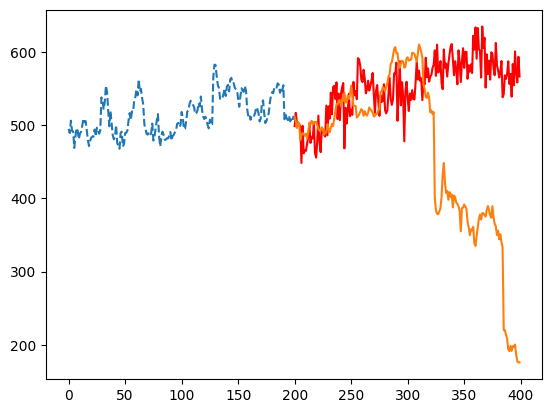

In [ ]:
closing_price_index = feature_columns.index('Close')

obs = X[-pred_sequences:].reshape(-1, input_dim)

rescaled_preds = feature_scaler.inverse_transform(preds)
rescaled_obs = feature_scaler.inverse_transform(obs)

closing_price_pred = rescaled_preds[:, [closing_price_index]]
closing_price_obs = rescaled_obs[:, [closing_price_index]]

plt.plot(range(seed_sequences * sequence_length), closing_price_pred[:seed_sequences * sequence_length], '--')
plt.plot(range(sequence_length * seed_sequences, len(closing_price_pred)), closing_price_pred[sequence_length * seed_sequences:], 'r')
plt.plot(range(sequence_length * seed_sequences, len(closing_price_pred)), closing_price_obs)

In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim

# import numpy as np

# import matplotlib.pyplot as plt


# class Sequence(nn.Module):

#     def __init__(self, hidden_dim=128, num_layers=2):
#         super(Sequence, self).__init__()
#         self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
#         self.fully_connected = nn.Linear(in_features=hidden_dim, out_features=1)

#     def forward(self, inputs):
#         outputs, _ = self.lstm(inputs)
#         outputs = self.fully_connected(outputs)
#         return outputs

#     def predict(self, inputs, steps):
#         with torch.no_grad():
#             for _ in range(steps):
#                 output = self(inputs)[:, -1, :].unsqueeze(1)
#                 inputs = torch.cat((inputs, output), dim=1)
#         return inputs


# epochs = 100
# device = torch.device("mps")

# num_periods = 10
# num_samples = 1000
# # num_train_batches = 100
# num_train_batches = 2

# x = np.linspace(0, 2 * np.pi * num_periods, num_samples)
# phi = np.random.rand(num_train_batches, 1) * 180 - 90
# data = np.sin(x + phi)

# train_inputs = torch.from_numpy(data[:, :-1]).float().to(device).unsqueeze(-1)
# train_targets = torch.from_numpy(data[:, 1:]).float().to(device)
# test_inputs = torch.from_numpy(data[:, :-1]).float().to(device).unsqueeze(-1)
# test_targets = torch.from_numpy(data[:, 1:]).float().to(device)

# model = Sequence().to(device)

# criterion = nn.MSELoss()
# optimizer = optim.AdamW(model.parameters(), lr=1e-3)

# progress = tqdm(range(epochs))
# for epoch in progress:
#     optimizer.zero_grad()
#     outputs = model(train_inputs)
#     loss = criterion(outputs.squeeze(), train_targets)
#     progress.set_description(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")
#     loss.backward()
#     optimizer.step()

# seed_steps = 50
# steps = 1000

# preds = test_inputs.clone()[0, :seed_steps].unsqueeze(0).to(device)
# with torch.no_grad():
#     for _ in tqdm(range(steps)):
#         output = model(preds)[:, -1, :].unsqueeze(1)
#         preds = torch.cat((preds, output), dim=1)

# preds = preds.detach().cpu().numpy().squeeze()

# plt.plot(range(seed_steps), preds[:seed_steps], '--')
# plt.plot(range(seed_steps, len(preds)), preds[seed_steps:], 'r')